# Machine Learning Project

## Table of Contents
- [Import Data](#import-data)
  - [Import Data Summary](#import-data-summary)
- [Data Exploration](#data-exploration)
  - [Boolean Features](#boolean-features)
    - [Boolean Features Analysis](#boolean-features-analysis)
  - [Categorical Features](#categorical-features)
    - [Check Categorical Features Consistency](#check-categorical-features-consistency)
    - [Categorical Features Summary](#categorical-features-summary)
  - [Numerical Features](#numerical-features)
    - [Numerical Plots](#plots)
    - [Analysis of Numerical Distributions](#analysis-of-numerical-distributions)
- [Pre-processing](#pre-processing)
  - [Summary of Preprocessing Pipeline](#preprocessing-pipeline-summary)
  - [Data Preparation](#data-preparation)
    - [Correlation Analysis](#correlation-analysis)
- [Model Training](#model-training)
  - [Model Selection with Cross-Validation](#model-selection-with-cv)
  - [Quick Baseline Model](#quick-baseline-model)
  - [Experiment Algorithms](#experiment-algorithms)
- [Predictions](#predictions)

# Abstract

### Context:
This project addresses car price prediction—a fundamental regression task in machine learning. The dataset includes features spanning categorical attributes (brand, model, transmission type, fuel type) and numerical characteristics (mileage, engine size, tax, MPG, paint quality). This problem is relevant for automotive valuations, insurance pricing, and market analysis.

### Objectives:
The primary goals were to:
1.  Systematically explore and preprocess complex, real-world automotive data containing missing values, outliers, and inconsistencies.
2.  Develop a robust preprocessing pipeline that prevents data leakage through proper fold-wise application.
3.  Benchmark multiple regression algorithms with hyperparameter tuning via cross-validation.
4.  Identify the most influential features through importance analysis.

### Methodology:
Data exploration revealed categorical inconsistencies (typos, spacing variations) and numerical anomalies (negative values, out-of-range percentages). The preprocessing pipeline incorporated:
* General cleaning
* Categorical standardization using edit distance
* Outlier handling via IQR method
* Imputation with training-set medians
* One-hot encoding
* Feature normalization


### Main Results:
**Ridge regression** with log-transformed targets established a baseline (MAE on validation). Feature importance revealed that `mileage`, `year`, and `engine size` are primary predictors, while `hasDamage` and certain categorical overflow categories contributed minimal signal. The hyperparameter tuning identified optimal configurations for each algorithm, with **ensemble methods** generally outperforming linear approaches. Cross-validation metrics tracked both training and validation performance to detect overfitting.

### Conclusions:
The project demonstrates that systematic preprocessing and ensemble approaches significantly improve prediction accuracy. Feature engineering and selection based on importance analysis reduced model complexity while preserving predictive power, supporting the principle that data quality and feature selection are as critical as algorithm choice in regression tasks.

<a id="import-data"></a>
## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, randint
from model_training_utils import (
    general_cleaning,
    preprocess_data,
    cross_validate_with_tuning,
    preprocess_test_data,
    get_feature_importance
)

SEED = 123
LOG_TARGET = True
DEMO_MODE = False


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [4]:
num_duplicated_ids = df.index.duplicated().sum()
print(f'Number of duplicated carIDs: {num_duplicated_ids}')

Number of duplicated carIDs: 0


<a id="import-data-summary"></a>
#### Import Data Summary
- Dataset loaded successfully with `carID` as the index
- There are no duplicate entries in carID
- The dataset contains information about cars including both numerical features (price, mileage, tax, etc.) and categorical features (brand, model, transmission, etc.)
- Initial inspection shows multiple features that will require preprocessing:
  - Numerical features that need cleaning (negative values, outliers)
  - Categorical features that need standardization
  - Presence of missing values in several columns

<a id="data-exploration"></a>
## Data Exploration

<a id="boolean-features"></a>
### Boolean Features

In [5]:
df['hasDamage'].value_counts(dropna=False)

hasDamage
0.0    74425
NaN     1548
Name: count, dtype: int64

<a id="boolean-features-analysis"></a>
#### Boolean Features Analysis

Key observations about `hasDamage` feature:
- Only contains binary values (0) and NaN
- No instances of value 1 found, suggesting potential data collection issues
- May indicate:
  - Cars with damage not being listed
  - System default setting of 0 for non-damaged cars
  - Incomplete damage assessment process
- Requires special handling in preprocessing:
  - Consider treating NaN as a separate category
  - Validate if 0 truly represents "no damage"
  - May need to be treated as a categorical rather than boolean feature

<a id="categorical-features"></a>
### Categorical Features

<a id="check-categorical-features-consistency"></a>
#### Check Categorical Features Consistency

In [6]:
# List of categorical features
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

# Identify outlier examples in categorical features
cat_outliers_examples = {col: df[col].value_counts().tail(10).index for col in cat_cols}

# Display the outlier examples
pd.DataFrame(cat_outliers_examples)

,Brand,model,fuelType,transmission
0,mercede,GOLF SV,Othe,utomati
1,kod,tiguan,ther,manual
2,AUD,CLK,Electric,AUTOMATI
3,KODA,gtc,YBRID,emi-Aut
4,HYUNDA,Gol,OTHER,Other
5,OYOTA,M5,other,semi-aut
6,SKOD,gls class,HYBRI,manua
7,TOYOT,Mokka,ybri,UTOMATIC
8,skod,6 Serie,ETRO,manual
9,toyot,JETTA,IESE,nknow


<a id="categorical-features-summary"></a>
#### Categorical Features Summary
- Initial analysis reveals significant data quality issues across all categorical columns
- No standardization in categorical features, with multiple variations of the same values (different spellings, capitalizations)
- Solution: We will implement string distance-based standardization using the `nltk` library to clean and standardize these features

<a id="numerical-features"></a>
### Numerical Features

In [7]:
# Dict of numerical features
num_cols = {
    'price': 'continuous',
    'mileage': 'continuous',
    'tax': 'continuous',
    'mpg': 'continuous',
    'paintQuality%': 'continuous',
    'engineSize': 'continuous',
    'year': 'discrete',
    'previousOwners': 'discrete'
}

<a id="plots"></a>
#### Numerical Plots

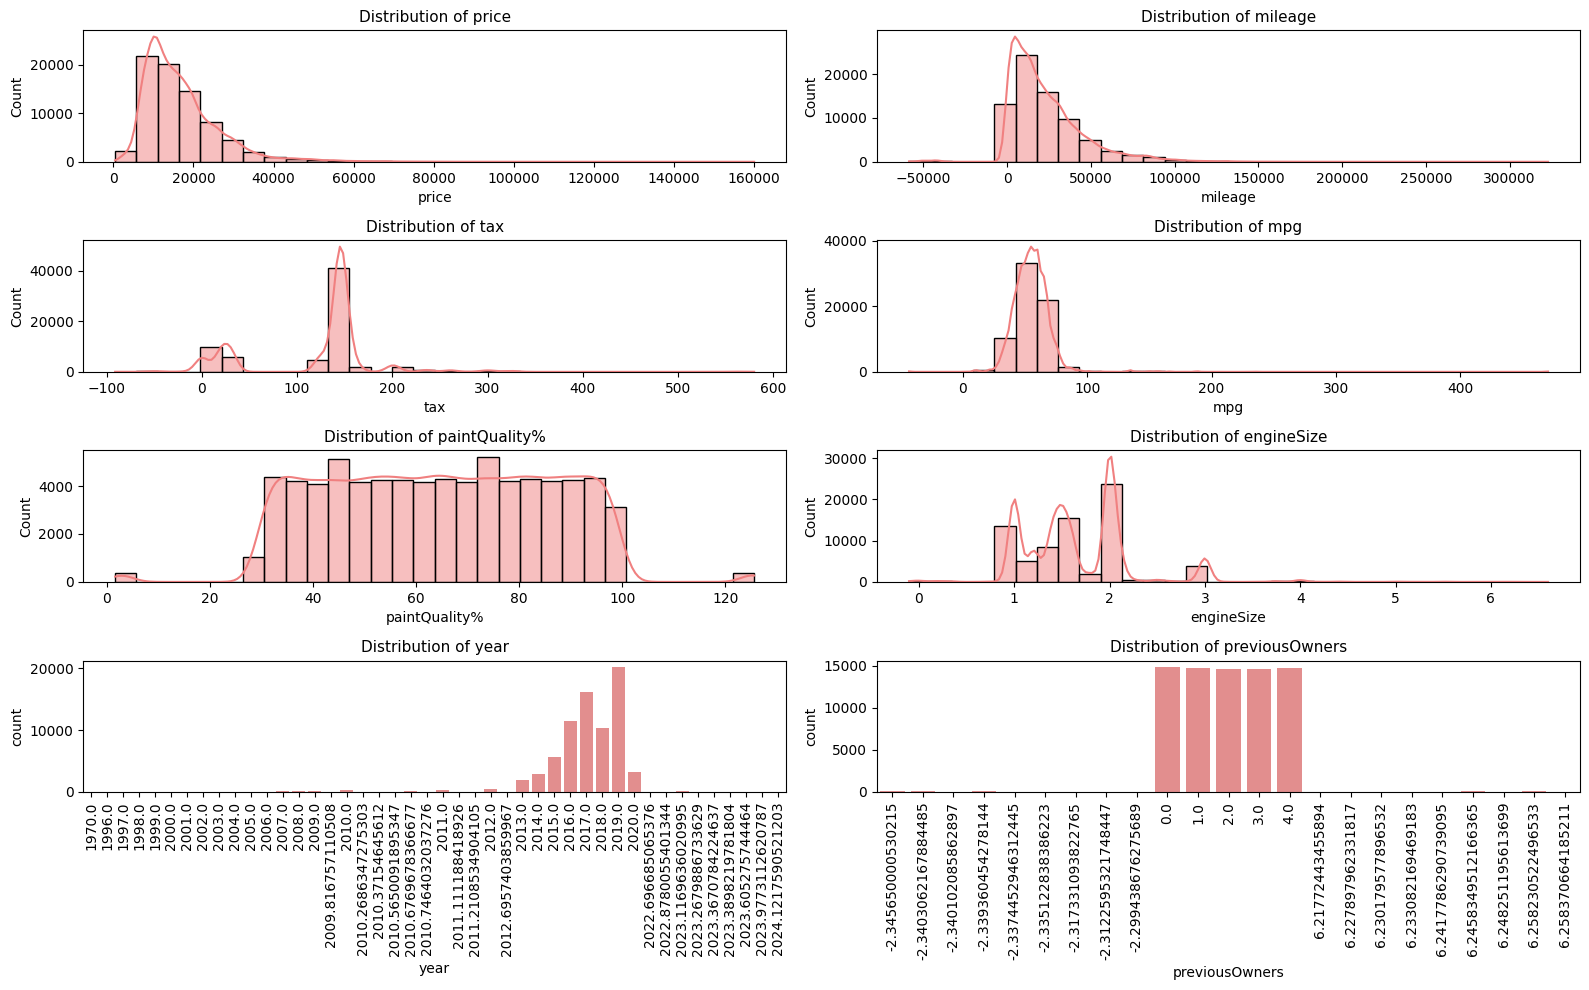

In [8]:
# Plot figures for numerical features and the target variable (price)
plt.figure(figsize=(16, 10))
for i, (col, var_type) in enumerate(num_cols.items(), 1):
    plt.subplot(4, 2, i)

    # Plot based on variable type
    if var_type == 'continuous':
        sns.histplot(data=df, x=col, kde=True, color="lightcoral", bins=30)
        plt.title(f"Distribution of {col}", fontsize=11)
    elif var_type == 'discrete':
        sns.countplot(data=df, x=col, color="lightcoral")
        plt.title(f"Distribution of {col}", fontsize=11)
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

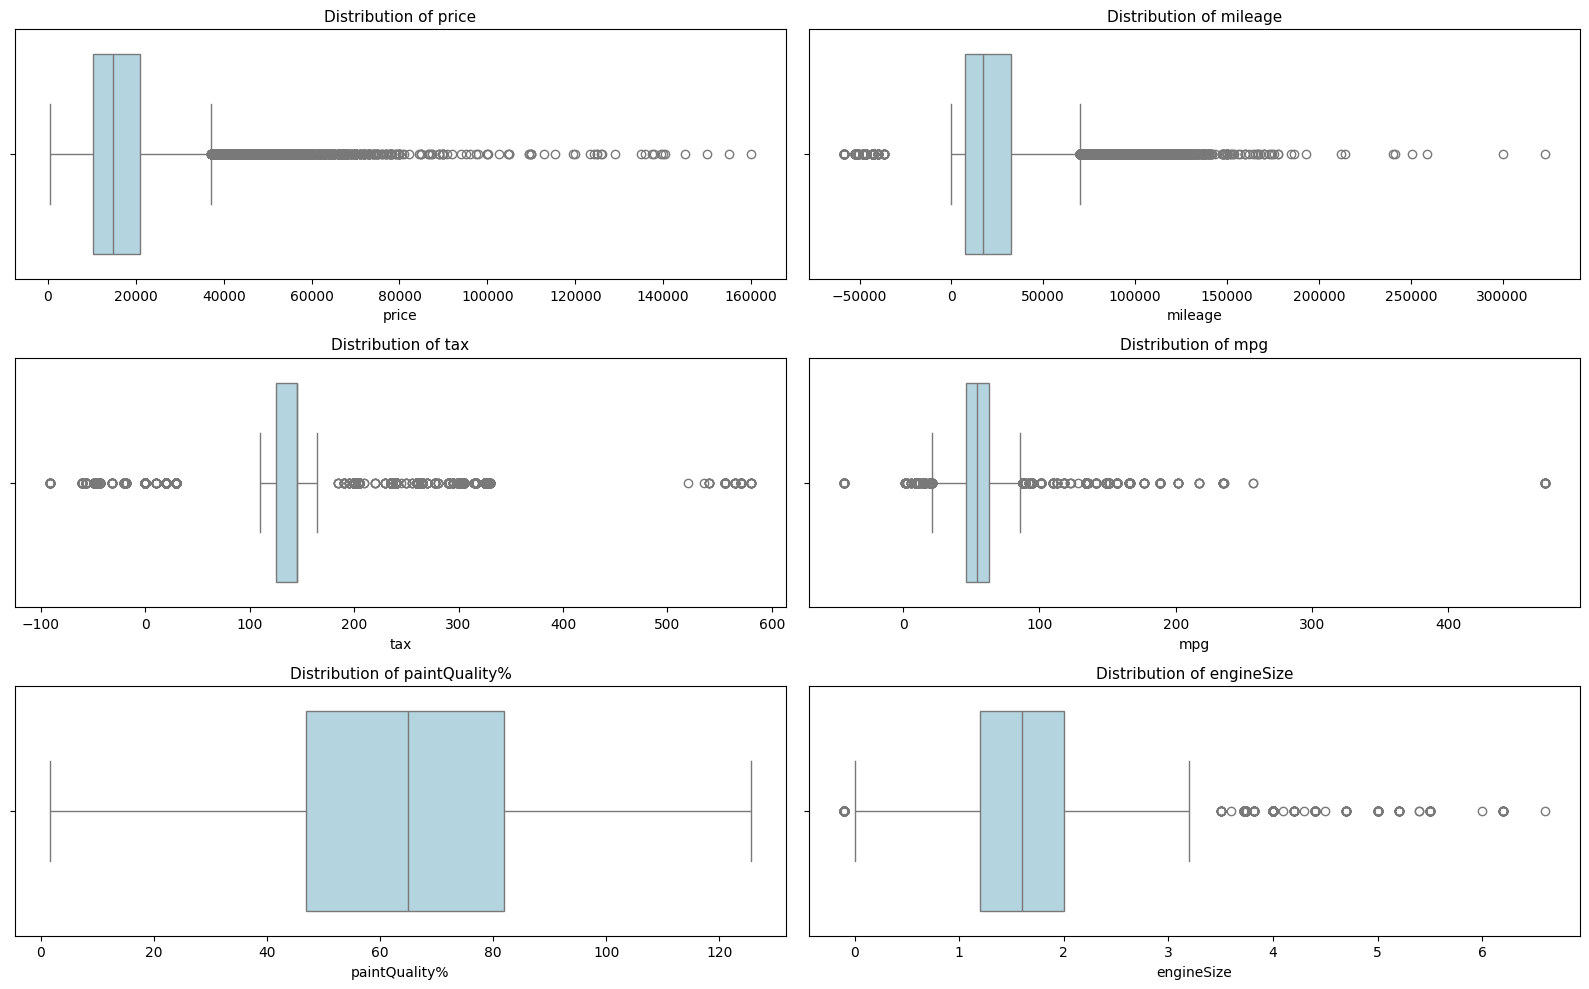

In [9]:
# Boxplots for continuous numerical features and the target variable (price)
continuous_cols = [col for col, var_type in num_cols.items() if var_type == 'continuous']
plt.figure(figsize=(16, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color="lightblue")
    plt.title(f"Distribution of {col}", fontsize=11)

plt.tight_layout()
plt.show()

<a id="analysis-of-numerical-distributions"></a>
#### Analysis of Numerical Distributions

Key observations from the plots:
- **Target Variable (Price)**:
  - Highly right-skewed distribution
  - Contains significant number of outliers in the upper range
  - Most cars are concentrated in the lower price range

- **Mileage**:
  - Right-skewed distribution
  - Large range from nearly new cars to high-mileage vehicles
  - Some outliers in upper range suggesting possible data entry errors

- **Tax**:
  - Multiple peaks suggesting different tax bands
  - Contains negative values which require investigation (possible tax benefits/rebates)
  - Large number of outliers on both ends of the distribution

- **MPG (Miles Per Gallon)**:
  - Approximately normal distribution with slight right skew
  - Some unrealistic extreme values that need cleaning
  - Reasonable median around typical car efficiency ranges

- **Paint Quality %**:
  - Contains values above 100% which are logically impossible
  - Left-skewed distribution suggesting optimistic ratings
  - Requires standardization to 0-100 range

- **Engine Size**:
  - There are engine size with zero values which are not realistic (might indicate electric vehicles)
  - Some unusual patterns that need investigation
  - Contains outliers that may represent specialty vehicles

- **Year**:
  - Should be discrete but contains decimal values

- **Previous Owners**:
  - Should be integer but contains float values
  - Right-skewed distribution as expected
  - Maximum values need validation (unusually high number of previous owners)

<a id="pre-processing"></a>
## Pre-processing

<a id="preprocessing-pipeline-summary"></a>
## Summary of Preprocessing Pipeline

The preprocessing is now properly separated:

1. **`preprocess_data()`** - Preprocesses a single dataset
   - Handles categorical features (standardization, encoding)
   - Handles numerical outliers using IQR method
   - Imputes missing values with medians
   - One-hot encodes categorical features
   - Normalizes numerical features with StandardScaler
   - Can fit transformers (fit=True) or use existing ones (fit=False)

2. **`cross_validate_with_tuning()`** - Performs CV with hyperparameter tuning
   - Takes **raw data** (after general_cleaning)
   - Applies preprocessing **separately for each fold** (prevents data leakage)
   - Performs manual hyperparameter search by sampling from parameter distributions
   - Evaluates each combination on validation fold and tracks train/validation performance
   - Returns best model configurations

3. **`preprocess_test_data()`** - Preprocesses test data
   - Uses artifacts from CV to ensure consistency

<a id="data-preparation"></a>
### Data Preparation

In [10]:
# Prepare cleaned data for cross-validation
df_cleaned = general_cleaning(df)
X = df_cleaned.drop(columns=["price"])
y = df_cleaned["price"]

# Remove 'price' from num_cols since it's the target
del num_cols['price']

print(f"Dataset size: {X.shape}")
print(f"Target range: £{y.min():.2f} - £{y.max():.2f}")


Dataset size: (75973, 12)
Target range: £450.00 - £159999.00


<a id="correlation-analysis"></a>
#### Correlation Analysis

Before model training, let's examine correlations between numerical features to understand their relationships.

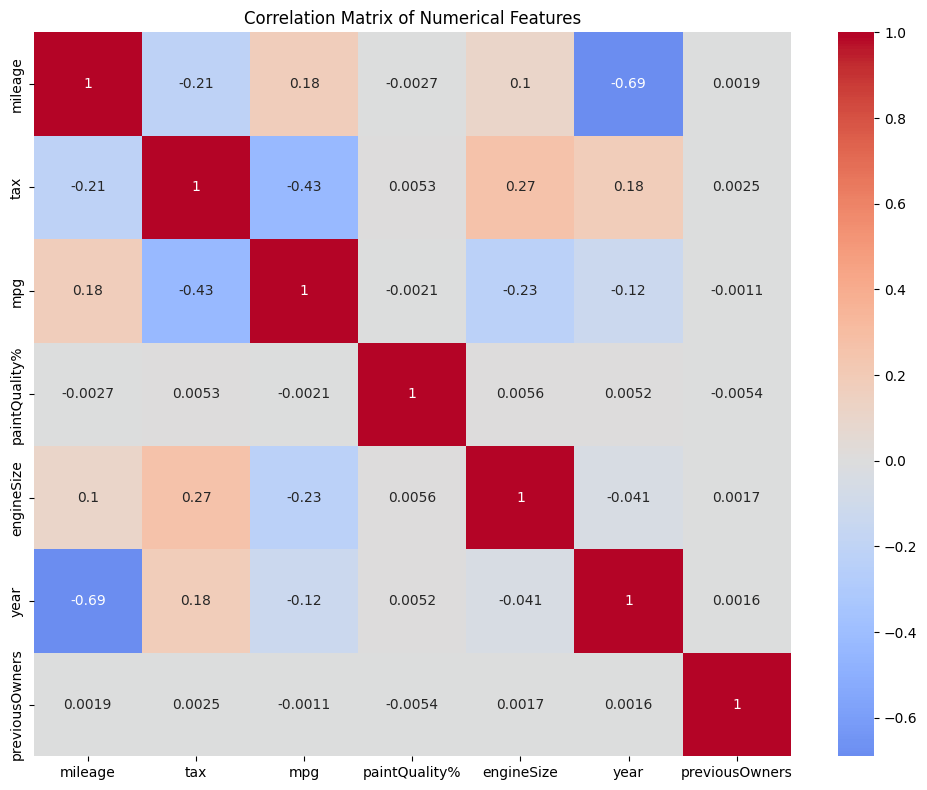

In [11]:
# Correlation matrix for numerical features
fig = plt.figure(figsize=(10, 8))
corr = X[list(num_cols.keys())].corr(method="pearson")
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

<a id="model-training"></a>
## Model Training

<a id="model-selection-with-cv"></a>
### Model Selection with Cross-Validation

We'll use cross-validation with hyperparameter tuning to select the best model. Configure your model using a dictionary with the model class, parameter distributions, and number of iterations.

<a id="quick-baseline-model"></a>
### Quick Baseline Model

Before running extensive CV, let's train a simple baseline model for quick reference.

In [12]:
# Quick train/val split for baseline
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Preprocess baseline data
X_train_processed, baseline_artifacts = preprocess_data(X_train_baseline, cat_cols, num_cols, fit=True, y=y_train_baseline)
X_val_processed = preprocess_data(X_val_baseline, cat_cols, num_cols, artifacts=baseline_artifacts, fit=False)

# 1. Baseline WITH Log Transform
baseline_model_log = Ridge(alpha=1.0, fit_intercept=True)
baseline_model_log.fit(X_train_processed, np.log1p(y_train_baseline))

y_train_pred_log = np.expm1(baseline_model_log.predict(X_train_processed))
y_val_pred_log = np.expm1(baseline_model_log.predict(X_val_processed))

mae_train_log = mean_absolute_error(y_train_baseline, y_train_pred_log)
mae_val_log = mean_absolute_error(y_val_baseline, y_val_pred_log)
r2_val_log = r2_score(y_val_baseline, y_val_pred_log)

print(f"Baseline Ridge (WITH Log Transform):")
print(f"  Train MAE: £{mae_train_log:.2f}")
print(f"  Val MAE:   £{mae_val_log:.2f}")
print(f"  Val R²:    {r2_val_log:.4f}")

# 2. Baseline WITHOUT Log Transform
baseline_model_no_log = Ridge(alpha=1.0, fit_intercept=True)
baseline_model_no_log.fit(X_train_processed, y_train_baseline)

y_train_pred_no_log = baseline_model_no_log.predict(X_train_processed)
y_val_pred_no_log = baseline_model_no_log.predict(X_val_processed)

mae_train_no_log = mean_absolute_error(y_train_baseline, y_train_pred_no_log)
mae_val_no_log = mean_absolute_error(y_val_baseline, y_val_pred_no_log)
r2_val_no_log = r2_score(y_val_baseline, y_val_pred_no_log)

print(f"\nBaseline Ridge (WITHOUT Log Transform):")
print(f"  Train MAE: £{mae_train_no_log:.2f}")
print(f"  Val MAE:   £{mae_val_no_log:.2f}")
print(f"  Val R²:    {r2_val_no_log:.4f}")

Baseline Ridge (WITH Log Transform):
  Train MAE: £2619.08
  Val MAE:   £2589.71
  Val R²:    0.8195

Baseline Ridge (WITHOUT Log Transform):
  Train MAE: £3076.20
  Val MAE:   £3027.40
  Val R²:    0.7703


<a id="feature-importance-analysis"></a>
### Feature Importance Analysis

In this section, we will train 4 different models (Ridge, Random Forest, Gradient Boosting, and Extra Trees) to analyze feature importance. Based on the results, we will select a subset of features to use for the final hyperparameter tuning.

In [13]:
# Models for Feature Importance Analysis
# We use default parameters or a small search space for quick analysis

# 1. Ridge (Linear)
print("--- Ridge Feature Importance ---")
fi_ridge_config = {
    'model_class': Ridge, 
    'param_distributions': {'alpha': 1}, 
    'n_iter': 1
}
fi_ridge_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_ridge_config, k=3, seed=SEED, verbose=False
)

# 2. Lasso (Linear)
print("\n--- Lasso Feature Importance ---")
fi_lasso_config = {
    'model_class': Lasso, 
    'param_distributions': {'alpha': 0.01}, 
    'n_iter': 1
}
fi_lasso_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_lasso_config, k=3, seed=SEED, verbose=False
)

# 3. Random Forest
print("\n--- Random Forest Feature Importance ---")
fi_rf_config = {
    'model_class': RandomForestRegressor, 
    'param_distributions': {'n_estimators': [100], 'max_depth': [10]}, 
    'n_iter': 1
}
fi_rf_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_rf_config, k=3, seed=SEED, verbose=False
)

# 4. Gradient Boosting
print("\n--- Gradient Boosting Feature Importance ---")
fi_gb_config = {
    'model_class': GradientBoostingRegressor, 
    'param_distributions': {'n_estimators': [100], 'max_depth': [5]}, 
    'n_iter': 1
}
fi_gb_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_gb_config, k=3, seed=SEED, verbose=False
)

# 5. Extra Trees
print("\n--- Extra Trees Feature Importance ---")
fi_et_config = {
    'model_class': ExtraTreesRegressor, 
    'param_distributions': {'n_estimators': [100], 'max_depth': [10]}, 
    'n_iter': 1
}
fi_et_results = cross_validate_with_tuning(
    X, y, cat_cols, num_cols, fi_et_config, k=3, seed=SEED, verbose=False
)

--- Ridge Feature Importance ---

--- Lasso Feature Importance ---

--- Random Forest Feature Importance ---

--- Gradient Boosting Feature Importance ---

--- Extra Trees Feature Importance ---


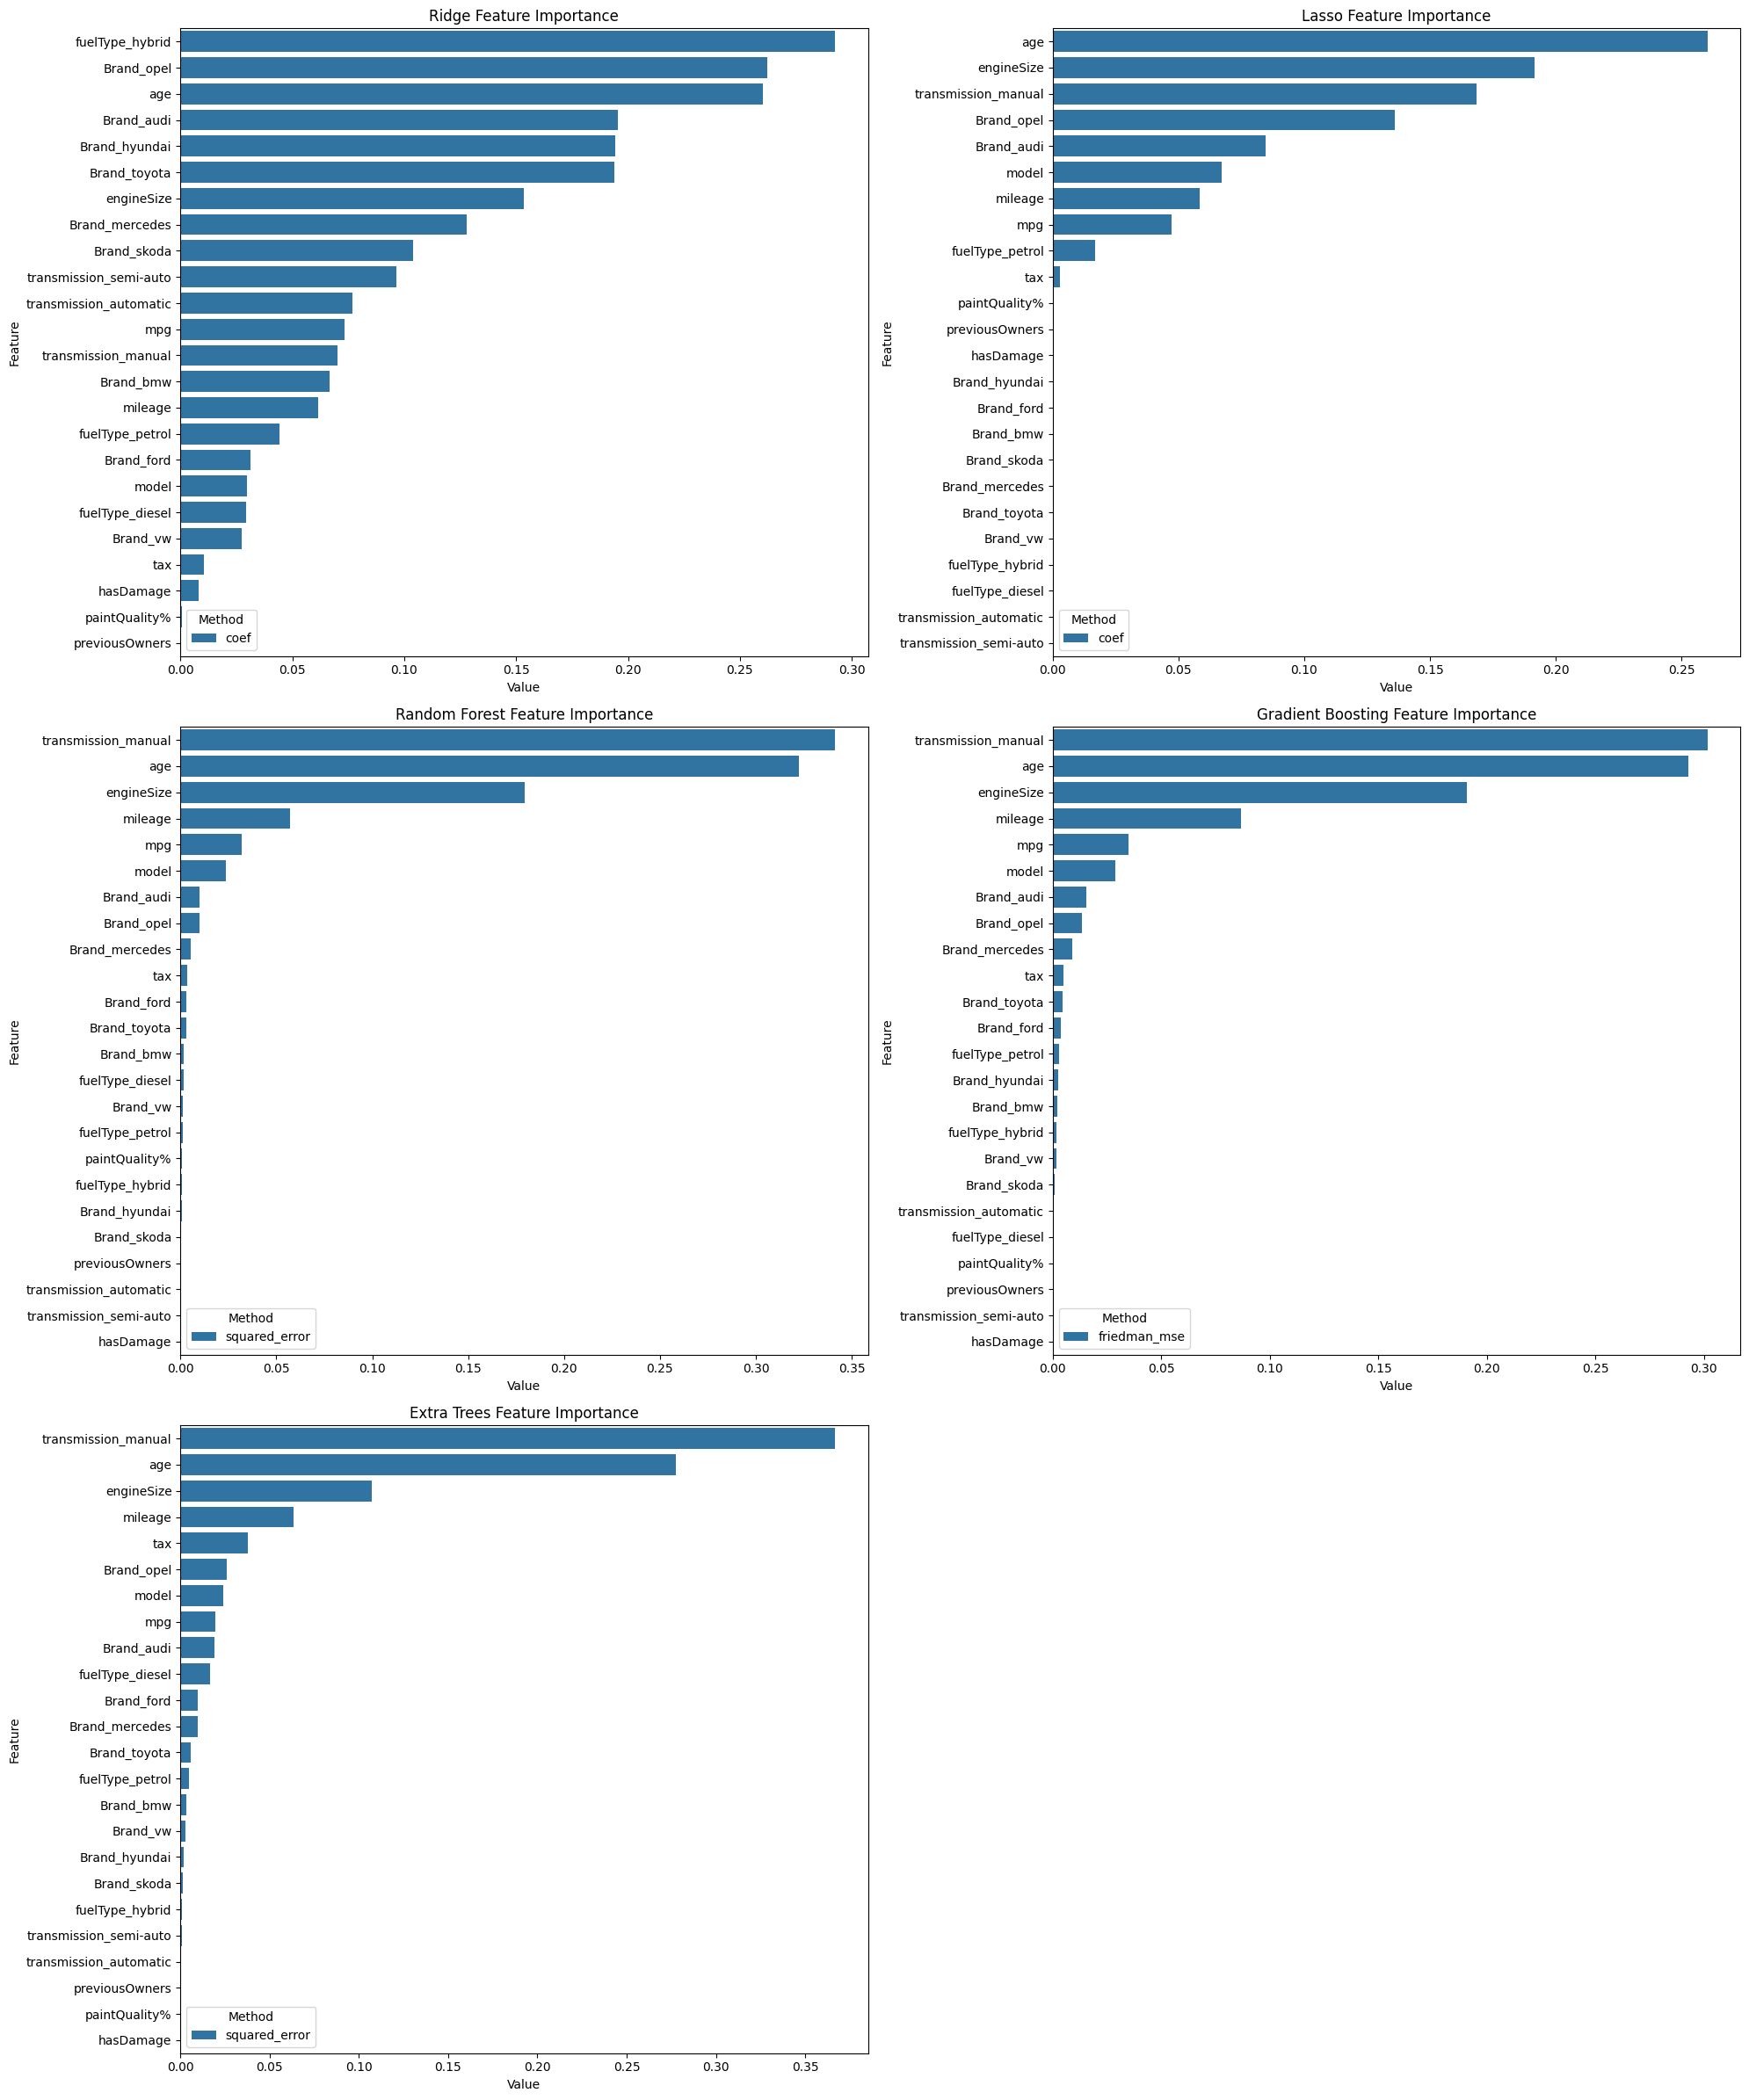

In [14]:
# Plot Feature Importance for all models
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

models_to_plot = [
    ('Ridge', fi_ridge_results),
    ('Lasso', fi_lasso_results),
    ('Random Forest', fi_rf_results),
    ('Gradient Boosting', fi_gb_results),
    ('Extra Trees', fi_et_results)
]

for i, (name, result) in enumerate(models_to_plot):
    ax = axes[i]
    X_processed = preprocess_data(X, cat_cols, num_cols, artifacts=result['final_artifacts'], fit=False)
    get_feature_importance(result['best_estimator'], X_processed, plot=True, ax=ax)
    ax.set_title(f"{name} Feature Importance")

# Hide empty subplot if any
if len(models_to_plot) < len(axes):
    for j in range(len(models_to_plot), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Get the list of all processed feature names from one of the artifacts
all_features = list(preprocess_data(X, cat_cols, num_cols, artifacts=fi_ridge_results['final_artifacts'], fit=False).columns)

print("Original Feature Count:", len(all_features))

# Collect feature importance from all models
feature_importance_df = pd.DataFrame(index=all_features)

models_fi = {
    'Ridge': fi_ridge_results,
    'Lasso': fi_lasso_results,
    'Random Forest': fi_rf_results,
    'Gradient Boosting': fi_gb_results,
    'Extra Trees': fi_et_results
}

for name, result in models_fi.items():
    # Reconstruct processed X to match columns
    X_processed = preprocess_data(X, cat_cols, num_cols, artifacts=result['final_artifacts'], fit=False)
    
    # Get importance dataframe (plot=False to avoid duplicate plots)
    imp_df = get_feature_importance(result['best_estimator'], X_processed, plot=False)
    
    # Map values to the main dataframe
    imp_series = imp_df.set_index('Feature')['Value']
    feature_importance_df[name] = imp_series

# Normalize each column to 0-1 range
scaler = MinMaxScaler()
feature_importance_normalized = pd.DataFrame(
    scaler.fit_transform(feature_importance_df.fillna(0)), 
    columns=feature_importance_df.columns, 
    index=feature_importance_df.index
)

# Calculate mean importance
feature_importance_normalized['Mean_Importance'] = feature_importance_normalized.mean(axis=1)
feature_importance_normalized = feature_importance_normalized.sort_values('Mean_Importance', ascending=False)

print("\nTop 15 Features by Mean Importance:")
print(feature_importance_normalized['Mean_Importance'].head(15))

# Selection Strategy: Keep features with mean importance > 0.005
threshold = 0.005
selected_features = feature_importance_normalized[feature_importance_normalized['Mean_Importance'] > threshold].index.tolist()

print(f"\nSelected {len(selected_features)} features (Mean Importance > {threshold}).")
print(f"Dropped {len(all_features) - len(selected_features)} features: {list(set(all_features) - set(selected_features))}")

Original Feature Count: 24

Top 15 Features by Mean Importance:
age                       0.912207
transmission_manual       0.777408
engineSize                0.542042
Brand_opel                0.312769
Brand_audi                0.225160
mileage                   0.212302
fuelType_hybrid           0.202002
Brand_toyota              0.140175
mpg                       0.138906
Brand_hyundai             0.135546
model                     0.117966
Brand_mercedes            0.101625
Brand_skoda               0.072467
transmission_semi-auto    0.066572
transmission_automatic    0.053000
Name: Mean_Importance, dtype: float64

Selected 22 features (Mean Importance > 0.005).
Dropped 2 features: ['previousOwners', 'paintQuality%']


<a id="experiment-algorithms"></a>
### Experiment Algorithms

Now we'll experiment with different algorithms using cross-validation with hyperparameter tuning.

In [16]:
# Example 0: Linear Regression
lr_config = {
    'model_class': LinearRegression,
    'param_distributions': {
        'fit_intercept': [True, False]
    },
    'n_iter': 2
}

lr_results = cross_validate_with_tuning(
    X, 
    y, 
    cat_cols, 
    num_cols, 
    lr_config, 
    k=3, 
    seed=SEED, 
    selected_features=selected_features, 
    log_target=True
)

Starting 3-Fold CV with LinearRegression (2 hyperparam combinations)...

Refitting best model on all available data...
Fitted 6 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  fit_intercept
    2612.8746      12.6703           True
    4373.2093      31.1460          False

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2623.13    | £2600.00   
2      | £2610.90    | £2608.52   
3      | £2599.18    | £2630.11   
------------------------------------
Mean CV MAE: £2612.87 ± £12.67
Best Fold MAE: £2600.00



In [17]:
# Example 1: Ridge Regression with hyperparameter tuning
ridge_config = {
    'model_class': Ridge,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False]
    },
    'n_iter': 20
}

ridge_results = cross_validate_with_tuning(
    X, 
    y, 
    cat_cols, 
    num_cols, 
    ridge_config, 
    k=3, 
    seed=SEED, 
    selected_features=selected_features, 
    log_target=True
)

Starting 3-Fold CV with Ridge (20 hyperparam combinations)...

Refitting best model on all available data...
Fitted 60 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae   alpha  fit_intercept
    2612.5783      13.6844 52.3903           True
    2612.6072      13.3466 32.3823           True
    2612.6553      13.1404 21.5370           True
    2612.7733      12.8584  8.0264           True
    2612.8343      12.7433  3.0363           True

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2622.94    | £2598.83   
2      | £2610.92    | £2607.65   
3      | £2598.71    | £2631.25   
------------------------------------
Mean CV MAE: £2612.58 ± £13.68
Best Fold MAE: £2598.83



In [18]:
# Example 2: Lasso Regression
lasso_config = {
    'model_class': Lasso,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False]
    },
    'n_iter': 20
}

lasso_results = cross_validate_with_tuning(
    X, 
    y, 
    cat_cols, 
    num_cols, 
    lasso_config, 
    k=3, 
    seed=SEED, 
    selected_features=selected_features, 
    log_target=True
)

Starting 3-Fold CV with Lasso (20 hyperparam combinations)...

Refitting best model on all available data...
Fitted 60 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  alpha  fit_intercept
    2664.1727      19.1722 0.0034           True
    4166.9211      31.8568 0.0058          False
    4183.8279      31.7724 0.0051          False
    4232.8902      31.2628 0.0034          False
    5930.3482      30.3429 0.1252          False

Best Model Performance (Across Folds):
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2674.43    | £2643.06   
2      | £2664.54    | £2659.99   
3      | £2650.28    | £2689.46   
------------------------------------
Mean CV MAE: £2664.17 ± £19.17
Best Fold MAE: £2643.06



In [19]:
# Example 3: Random Forest
rf_results = None

if not DEMO_MODE:
    rf_config = {
        'model_class': RandomForestRegressor,
        'param_distributions': {
            'n_estimators': randint(100, 300),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 0.5, 0.75, 1.0],
            'n_jobs': [-1],
            'random_state': SEED
        },
        'n_iter': 30
    }

    rf_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        rf_config, 
        k=3, 
        seed=SEED, 
        selected_features=selected_features, 
        log_target=LOG_TARGET
    )
else:
    print("Skipping Random Forest in Demo Mode")

Starting 3-Fold CV with RandomForestRegressor (30 hyperparam combinations)...

Refitting best model on all available data...
Fitted 90 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  n_jobs  random_state
    1551.5260      12.6103           289        NaN                  4                 3         0.75      -1           123
    1552.8198      11.8759           217        NaN                 11                 2          0.5      -1           123
    1558.3386      12.3519           183       30.0                  7                 3          0.5      -1           123
    1565.4341      12.6372           160       30.0                 11                 3         0.75      -1           123
    1575.8234      10.2695           256       20.0                 16                 2         0.75      -1           123

Best Model Performance (Across Folds):
Fold  

In [20]:
# Example 4: Hist Gradient Boosting Regressor
hgb_results = None

if not DEMO_MODE:
    hgb_config = {
        'model_class': HistGradientBoostingRegressor,
        'param_distributions': {
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth': [None, 10, 20, 30],
            'max_leaf_nodes': randint(15, 63),
            'l2_regularization': loguniform(1e-3, 10),
            'max_iter': 1000,
            'early_stopping': True,
            'loss': ['absolute_error'],
            'random_state': SEED
        },
        'n_iter': 30
    }

    hgb_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        hgb_config, 
        k=3, 
        seed=SEED, 
        selected_features=selected_features, 
        log_target=LOG_TARGET
    )
else:
    print("Skipping Hist Gradient Boosting in Demo Mode")

Starting 3-Fold CV with HistGradientBoostingRegressor (30 hyperparam combinations)...

Refitting best model on all available data...
Fitted 90 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  learning_rate  max_depth  max_leaf_nodes  l2_regularization  max_iter  early_stopping           loss  random_state
    1487.0943      11.7880         0.1068       20.0              60             0.6108      1000            True absolute_error           123
    1498.4040      11.4565         0.1273       30.0              55             0.9809      1000            True absolute_error           123
    1506.1739      14.6975         0.1424       20.0              48             1.3293      1000            True absolute_error           123
    1506.5230       9.8916         0.0948       20.0              46             0.4419      1000            True absolute_error           123
    1507.1049       3.7303         0.0913       30.0              4

In [21]:
# Example 5: Gradient Boosting Regressor (Standard)
gb_results = None

if not DEMO_MODE:
    gb_config = {
        'model_class': GradientBoostingRegressor,
        'param_distributions': {
            'n_estimators': randint(50, 200),
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'subsample': [0.8, 0.9, 1.0],
            'random_state': SEED,
            'n_iter_no_change': [10],
            'validation_fraction': [0.1]
        },
        'n_iter': 30
    }

    gb_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        gb_config, 
        k=3, 
        seed=SEED, 
        selected_features=selected_features, 
        log_target=LOG_TARGET
    )
else:
    print("Skipping Gradient Boosting in Demo Mode")

Starting 3-Fold CV with GradientBoostingRegressor (30 hyperparam combinations)...

Refitting best model on all available data...
Fitted 90 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  learning_rate  max_depth  min_samples_split  min_samples_leaf  subsample  random_state  n_iter_no_change  validation_fraction
    1534.5734      16.8437           145         0.0696       20.0                  9                 8        0.9           123                10                  0.1
    1537.3076      21.3973           174         0.0948       10.0                 13                 6        0.8           123                10                  0.1
    1538.0495      15.7316           148         0.0544       10.0                  4                 3        1.0           123                10                  0.1
    1539.3178      17.7459           133         0.0708       10.0                 16                 4        0.8

In [22]:
# Example 6: Extra Trees Regressor
et_results = None

if not DEMO_MODE:
    et_config = {
        'model_class': ExtraTreesRegressor,
        'param_distributions': {
            'n_estimators': randint(100, 300),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 0.5],
            'n_jobs': [-1],
            'random_state': SEED
        },
        'n_iter': 30
    }

    et_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        et_config, 
        k=3, 
        seed=SEED, 
        selected_features=selected_features, 
        log_target=LOG_TARGET
    )
else:
    print("Skipping Extra Trees in Demo Mode")

Starting 3-Fold CV with ExtraTreesRegressor (30 hyperparam combinations)...

Refitting best model on all available data...
Fitted 90 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae  n_estimators  max_depth  min_samples_split  min_samples_leaf max_features  n_jobs  random_state
    1604.8206      16.0484           217        NaN                 11                 2          0.5      -1           123
    1635.2852      15.1573           183       30.0                  7                 3          0.5      -1           123
    1637.3656      16.0885           178        NaN                 16                 2          0.5      -1           123
    1689.6665      14.1004           138       30.0                  5                 4          0.5      -1           123
    1728.0864      12.0866           209       20.0                 15                 3          0.5      -1           123

Best Model Performance (Across Folds):
Fold   |

In [23]:
# Example 7: MLP Regressor (Neural Network)
mlp_results = None

if not DEMO_MODE:
    mlp_config = {
        'model_class': MLPRegressor,
        'param_distributions': {
            'hidden_layer_sizes': [(32,), (64,), (100,), (32, 16), (64, 32), (100, 50)],
            'activation': ['relu', 'tanh'],
            'solver': 'adam',
            'alpha': loguniform(1e-5, 1e-1),
            'learning_rate_init': loguniform(1e-4, 1e-2),
            'max_iter': 1000,
            'early_stopping': True,
            'random_state': SEED
        },
        'n_iter': 20
    }

    mlp_results = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        mlp_config, 
        k=3, 
        seed=SEED, 
        selected_features=selected_features, 
        log_target=LOG_TARGET
    )
else:
    print("Skipping MLP in Demo Mode")

Starting 3-Fold CV with MLPRegressor (20 hyperparam combinations)...

Refitting best model on all available data...
Fitted 60 models in total.
Features Selected: 22

Top 5 Hyperparameter Combinations:
 mean_val_mae  std_val_mae hidden_layer_sizes activation solver  alpha  learning_rate_init  max_iter  early_stopping  random_state
    1964.2637      36.4450             (100,)       relu   adam 0.0011              0.0010      1000            True           123
    1969.2665      21.7739             (100,)       relu   adam 0.0009              0.0010      1000            True           123
    1975.9825      13.6457             (100,)       relu   adam 0.0000              0.0002      1000            True           123
    1983.1234      26.9946           (64, 32)       tanh   adam 0.0000              0.0002      1000            True           123
    1998.4426      20.6406              (64,)       relu   adam 0.0019              0.0014      1000            True           123

Best Model P

### Final Model Selection

I will select the best algorithm with the best hyperparameters and train the model with it. While doing it I want to use all available data.

In [24]:
# Compare all models to find the best one
results = {
    'Linear Regression': lr_results,
    'Ridge': ridge_results,
    'Lasso': lasso_results,
    'Random Forest': rf_results,
    'Hist Gradient Boosting': hgb_results,
    'Gradient Boosting': gb_results,
    'Extra Trees': et_results,
    'MLP': mlp_results,
}

# Filter out None results
results = {k: v for k, v in results.items() if v is not None}

# Select the best model based on the lowest mean CV score (MAE)
best_model_name = min(results, key=lambda k: results[k]['mean_cv_score'])
best_result = results[best_model_name]

print(f"Best Model Selected: {best_model_name}")
print(f"Best CV MAE: £{best_result['mean_cv_score']:.2f} ± £{best_result['std_cv_score']:.2f}")
print(f"Best Parameters: {best_result['best_params']}\n")

# The function now returns the model already fitted on ALL available data
# and the corresponding preprocessing artifacts
best_model = best_result['best_estimator']
final_artifacts = best_result['final_artifacts']

print(f"Final model ({best_model_name}) is ready and fitted on all data.")

# Visualize Feature Importance (if applicable)
try:
    # We need the processed feature names for the plot
    X_all_processed = preprocess_data(X, cat_cols, num_cols, artifacts=final_artifacts, fit=False)
    
    # Filter selected features if they were used during training
    if 'selected_features' in final_artifacts:
        X_all_processed = X_all_processed[final_artifacts['selected_features']]
        
    get_feature_importance(best_model, X_all_processed, model_class=type(best_model))
except Exception as e:
    print(f"Could not plot feature importance: {e}")

Best Model Selected: Hist Gradient Boosting
Best CV MAE: £1487.09 ± £11.79
Best Parameters: {'learning_rate': 0.10684874790620232, 'max_depth': 20, 'max_leaf_nodes': 60, 'l2_regularization': 0.6107686573608484, 'max_iter': 1000, 'early_stopping': True, 'loss': 'absolute_error', 'random_state': 123}

Final model (Hist Gradient Boosting) is ready and fitted on all data.
Could not plot feature importance: Model HistGradientBoostingRegressor not supported or has no extractable importance.


## Ablation Analysis

In this section, we analyze the impact of different preprocessing steps on the model's performance. We use the best performing model identified above and retrain it with different preprocessing configurations.

We test the following configurations:
1. **Full Preprocessing**: The baseline (all steps enabled).
2. **No Outlier Cleaning**: Outliers are not removed/clipped.
3. **No Standardization**: Categorical variables are not standardized (rare categories are kept).
4. **No Normalization**: Numerical variables are not normalized.

Running Ablation Analysis on Best Model: Hist Gradient Boosting...

Testing configuration: Full Preprocessing
  -> MAE: £1504.51 ± £22.13

Testing configuration: No Outlier Cleaning
  -> MAE: £1479.40 ± £9.33

Testing configuration: No Standardization
  -> MAE: £1356.66 ± £4.41

Testing configuration: No Normalization
  -> MAE: £1504.51 ± £22.13

Testing configuration: No Log Target
  -> MAE: £1509.97 ± £8.74

Testing configuration: Minimal Preprocessing
  -> MAE: £1348.30 ± £14.74


Ablation Analysis Results:
        Configuration  Mean CV MAE  Std CV MAE  Impact (MAE Change)   Impact %
   Full Preprocessing  1504.512006   22.132510             0.000000   0.000000
  No Outlier Cleaning  1479.401948    9.332558           -25.110058  -1.668984
   No Standardization  1356.657827    4.410922          -147.854180  -9.827384
     No Normalization  1504.513722   22.134276             0.001716   0.000114
        No Log Target  1509.973663    8.744135             5.461657   0.363019
Minimal Pr

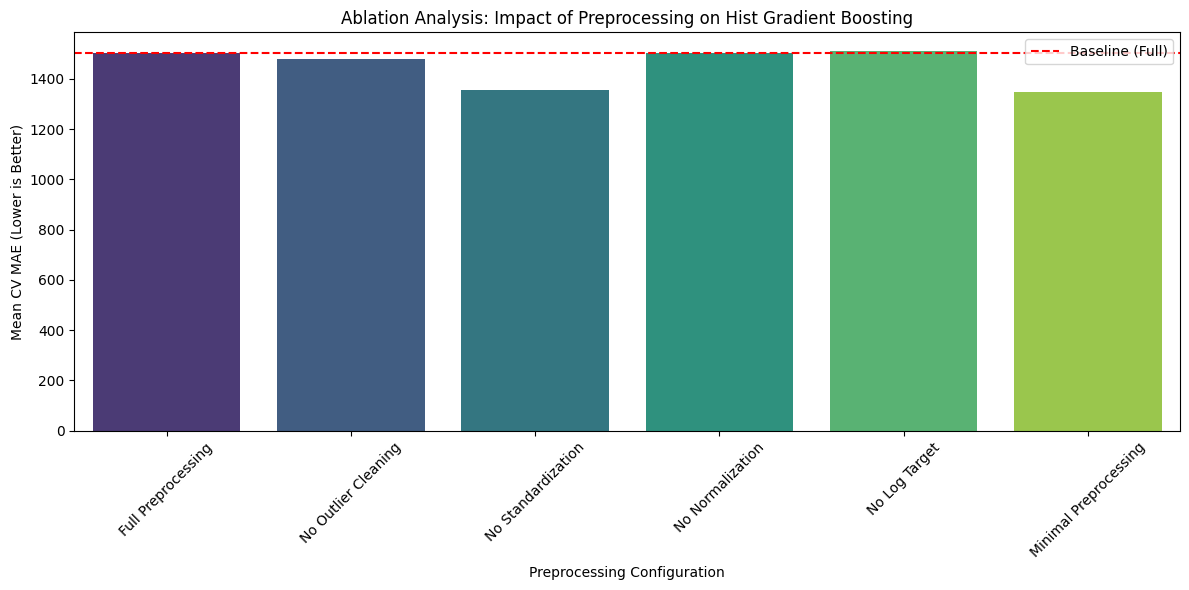


Best Preprocessing Configuration found: Minimal Preprocessing
Updated 'best_model' and 'final_artifacts' to use the 'Minimal Preprocessing' configuration for final predictions.


In [29]:
# Define ablation configurations
# Each config defines the preprocessing flags and whether to log-transform the target
ablation_configs = {
    'Full Preprocessing': {
        'preprocessing_params': {
            'clean_outliers_flag': True,
            'standardize_cats_flag': True,
            'normalize_flag': True
        },
        'log_target': True
    },
    'No Outlier Cleaning': {
        'preprocessing_params': {
            'clean_outliers_flag': False,
            'standardize_cats_flag': True,
            'normalize_flag': True
        },
        'log_target': True
    },
    'No Standardization': {
        'preprocessing_params': {
            'clean_outliers_flag': True,
            'standardize_cats_flag': False,
            'normalize_flag': True
        },
        'log_target': True
    },
    'No Normalization': {
        'preprocessing_params': {
            'clean_outliers_flag': True,
            'standardize_cats_flag': True,
            'normalize_flag': False
        },
        'log_target': True
    },
    'No Log Target': {
        'preprocessing_params': {
            'clean_outliers_flag': True,
            'standardize_cats_flag': True,
            'normalize_flag': True
        },
        'log_target': False
    },
    'Minimal Preprocessing': {
        'preprocessing_params': {
            'clean_outliers_flag': False,
            'standardize_cats_flag': False,
            'normalize_flag': False
        },
        'log_target': True
    }
}

ablation_results = []
ablation_full_outputs = {}

print(f"Running Ablation Analysis on Best Model: {best_model_name}...\n")

# Setup model config for the best model (fixed parameters)
ablation_model_config = {
    'model_class': best_result['best_estimator'].__class__,
    'param_distributions': {k: [v] for k, v in best_result['best_params'].items()},
    'n_iter': 1
}

for name, config in ablation_configs.items():
    print(f"Testing configuration: {name}")
    
    params = config['preprocessing_params']
    use_log_target = config['log_target']
    
    # Run CV with specific preprocessing params and log_target setting
    res = cross_validate_with_tuning(
        X, 
        y, 
        cat_cols, 
        num_cols, 
        ablation_model_config, 
        k=3, 
        seed=SEED, 
        selected_features=selected_features, 
        log_target=use_log_target,
        verbose=False,
        preprocessing_params=params
    )
    
    ablation_full_outputs[name] = res
    ablation_results.append({
        'Configuration': name,
        'Mean CV MAE': res['mean_cv_score'],
        'Std CV MAE': res['std_cv_score']
    })
    print(f"  -> MAE: £{res['mean_cv_score']:.2f} ± £{res['std_cv_score']:.2f}\n")

# Create DataFrame for results
ablation_df = pd.DataFrame(ablation_results)

# Calculate impact relative to baseline
baseline_score = ablation_df.loc[ablation_df['Configuration'] == 'Full Preprocessing', 'Mean CV MAE'].values[0]
ablation_df['Impact (MAE Change)'] = ablation_df['Mean CV MAE'] - baseline_score
ablation_df['Impact %'] = (ablation_df['Impact (MAE Change)'] / baseline_score) * 100

print("\nAblation Analysis Results:")
print(ablation_df.to_string(index=False))

# Plot results
plt.figure(figsize=(12, 6))
sns.barplot(data=ablation_df, x='Configuration', y='Mean CV MAE', palette='viridis')
plt.title(f'Ablation Analysis: Impact of Preprocessing on {best_model_name}')
plt.ylabel('Mean CV MAE (Lower is Better)')
plt.xlabel('Preprocessing Configuration')
plt.xticks(rotation=45)
plt.axhline(y=baseline_score, color='r', linestyle='--', label='Baseline (Full)')
plt.legend()
plt.tight_layout()
plt.show()

# Select best configuration and update model
best_config_name = ablation_df.sort_values('Mean CV MAE').iloc[0]['Configuration']
print(f"\nBest Preprocessing Configuration found: {best_config_name}")

# Update best_model and final_artifacts to use the best configuration
best_model = ablation_full_outputs[best_config_name]['best_estimator']
final_artifacts = ablation_full_outputs[best_config_name]['final_artifacts']

print(f"Updated 'best_model' and 'final_artifacts' to use the '{best_config_name}' configuration for final predictions.")

<a id="predictions"></a>
# Predictions

In [30]:
# Load and preprocess test data
test_df = pd.read_csv('data/test.csv').set_index('carID')

# Use the artifacts from the final fit on all data
test_processed = preprocess_test_data(test_df, final_artifacts)

# Make predictions
if final_artifacts.get('log_target', True):
    test_predictions = np.expm1(best_model.predict(test_processed))
else:
    test_predictions = best_model.predict(test_processed)

# Save predictions
predictions_df = pd.DataFrame({'price': test_predictions}, index=test_df.index)
predictions_df.to_csv('data/test_predictions.csv')

print(f"Predictions saved for {len(test_predictions)} test samples")
print(f"Predicted price range: £{test_predictions.min():.2f} - £{test_predictions.max():.2f}")

Predictions saved for 32567 test samples
Predicted price range: £1042.58 - £140691.84
